In [1]:
#from google.colab import drive; drive.mount('/content/drive')

google_drive_path = ''#'/content/drive/MyDrive/Colab/project/'

In [2]:
from datetime import datetime
start_kernel = datetime.now()

# Project
## Balázs Menkó (O67UT7)
---
# Genetic Engineering

In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
import pickle

fs=16 # fontsize

### SCIKIT-LEARN & TensorFlow ###        
from sklearn.decomposition import PCA 
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
### SCIKIT-LEARN & TensorFlow ###         

print('TensorFlow version:',tf.__version__)
print(tf.config.experimental.list_physical_devices())

TensorFlow version: 2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
def df_info(df, df_name='', cols_name=False):
    print(f"Shape of '{df_name}' dataframe --- cols: {df.shape[1]}; rows: {df.shape[0]}")
    if (df.isna().sum()==0).all():
        print('There are no missing values in the dataframe.\n')
    else:
        missing_values = df.isna().sum()
        print(f' Missing values:')
        print(missing_values[missing_values != 0]) 
        print(f' Sum: {missing_values.sum()}')
    if cols_name:
        return missing_values[missing_values != 0].to_frame().index.tolist()

def accuracy(y_pred, y_test, model_name='the', print_or_return=True):
    acc=(y_pred == y_test).sum()/len(y_test)
    if print_or_return:
        print(f'Accuracy of {model_name} model: {np.round(acc*100, 3)} %')
    else:
        return acc

def plot_history(train, val, loss_or_acc='', ylim=(None, None), save_as=False):
    print(f'Train {loss_or_acc}: {np.round(train[-1],3)}')
    print(f'Test {loss_or_acc}: {np.round(val[-1],3)}')
    plt.figure(figsize=(9,6))
    plt.plot(train, '--o', c='r', label=f'train {loss_or_acc}')
    plt.plot(val, '--o', c='b', label=f'test {loss_or_acc}')
    plt.title(loss_or_acc[0].upper() + loss_or_acc[1:] + ' of the model', fontsize=fs+3)
    plt.xlabel('epochs', fontsize=fs)
    plt.ylabel(loss_or_acc, fontsize=fs)
    plt.legend(fontsize=fs)
    plt.grid(ls='dotted')
    plt.ylim(*ylim)
    if save_as:
        plt.savefig(google_drive_path+'images/'+save_as+'.pdf', bbox_inches='tight')
    plt.show()
    return None

---
# Reading and preprocessing

In [5]:
data = pd.read_csv(google_drive_path+'source/train_values.csv')
data_seq = data.pop('sequence')
data_seq_id = data.pop('sequence_id')
labs = pd.read_csv(google_drive_path+'source/train_labels.csv')
labs_seq_id = labs.pop('sequence_id')

In [6]:
df_info(data, 'Train_values')
df_info(labs, 'Train_labels')

Shape of 'Train_values' dataframe --- cols: 39; rows: 63017
There are no missing values in the dataframe.

Shape of 'Train_labels' dataframe --- cols: 1314; rows: 63017
There are no missing values in the dataframe.



In [7]:
random_state = 42
data_shuffle = shuffle(np.array(data), random_state=random_state)
labs_shuffle = shuffle(np.array(labs), random_state=random_state)

x_tr, x_ts = np.split(data_shuffle, [int((0.8)*len(data))])
y_tr_ohe, y_ts_ohe = np.split(labs_shuffle, [int((0.8)*len(labs))])
y_tr = np.argmax(y_tr_ohe, axis=1)
y_ts = np.argmax(y_ts_ohe, axis=1)
print('x_train.shape:',x_tr.shape, '\n x_test.shape:', x_ts.shape)
print('y_train.shape:',y_tr.shape, '\n y_test.shape:', y_ts.shape)

x_train.shape: (50413, 39) 
 x_test.shape: (12604, 39)
y_train.shape: (50413,) 
 y_test.shape: (12604,)


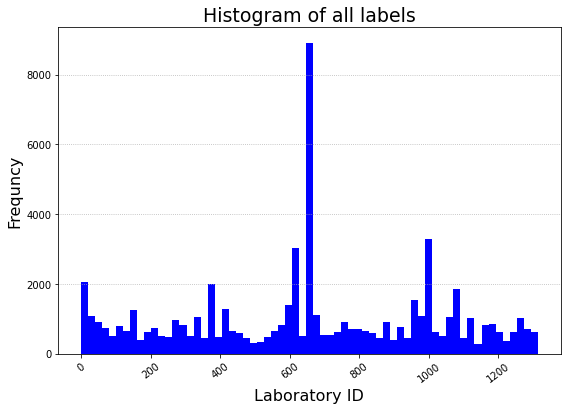

In [8]:
labels = np.argmax(labs.values, axis=1)

plt.figure(figsize=(9,6))
plt.grid(ls='dotted', axis='y')
plt.hist(labels, bins=int(max(np.unique(labels))/20), color='blue')
plt.title('Histogram of all labels', fontsize=fs+3)
plt.xlabel('Laboratory ID', fontsize=fs)
plt.xticks(rotation=37)
plt.ylabel('Frequncy', fontsize=fs)
plt.savefig(google_drive_path+'images/hist_labor_id.pdf', bbox_inches='tight')
plt.show()

In [9]:
freq, ids = np.histogram(labels, bins=int(max(np.unique(labels))), )
sorted_freq, sorted_ids = zip(*sorted(zip(freq, ids), reverse=True))
print('Top ten most frequent Labor in labels:')
for i in range(10):
    print(f"{i+1}. --- Labor ID - '{labs.columns[int(sorted_ids[i])]}' ({int(sorted_ids[i])}.) - freq={sorted_freq[i]}")

Top ten most frequent Labor in labels:
1. --- Labor ID - 'I7FXTVDP' (666.) - freq=8286
2. --- Labor ID - 'RKJHZGDQ' (1008.) - freq=2732
3. --- Labor ID - 'GTVTUGVY' (615.) - freq=2672
4. --- Labor ID - 'A18S09P2' (380.) - freq=1064
5. --- Labor ID - 'Q2K8NHZY' (951.) - freq=973
6. --- Labor ID - '131RRHBV' (31.) - freq=710
7. --- Labor ID - '0FFBBVE1' (12.) - freq=682
8. --- Labor ID - 'AMV4U0A0' (408.) - freq=664
9. --- Labor ID - 'THD393NW' (1074.) - freq=625
10. --- Labor ID - 'G8QWQL1C' (599.) - freq=576


## 1) PCA

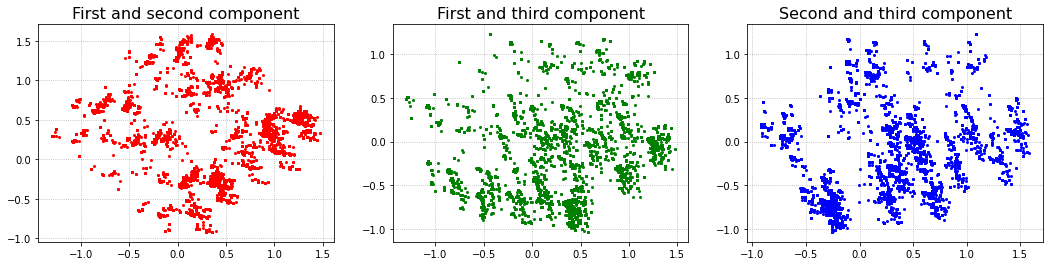

In [10]:
pca = PCA(3)
pca_tr = pca.fit_transform(data)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4) )

ax1.plot(pca_tr[:,0], pca_tr[:,1], 'o', ms=2, c='r')
ax1.set_title('First and second component', fontsize=fs)
ax1.grid(ls='dotted')

ax2.plot(pca_tr[:,0], pca_tr[:,2], 'o', ms=2, c='g')
ax2.set_title('First and third component', fontsize=fs)
ax2.grid(ls='dotted')

ax3.plot(pca_tr[:,1], pca_tr[:,2], 'o', ms=2, c='b')
ax3.set_title('Second and third component', fontsize=fs)
ax3.grid(ls='dotted')

plt.savefig(google_drive_path+'images/pca.jpg', bbox_inches='tight')
plt.show()

In [11]:
pca.components_[0][abs(pca.components_[0]).argsort()[::-1]]

array([ 4.89338117e-01, -4.67525320e-01, -4.03385939e-01,  3.94065114e-01,
       -2.94236715e-01, -2.13711213e-01, -2.06854135e-01,  1.26053946e-01,
       -9.19393786e-02,  7.23181433e-02,  6.81278143e-02,  5.47538898e-02,
        4.13426041e-02,  3.95458281e-02,  3.39842995e-02, -3.31219192e-02,
        3.29427130e-02,  3.17661802e-02,  2.62440506e-02,  2.49207850e-02,
        2.44990781e-02,  2.19409157e-02,  2.13111816e-02,  1.83959951e-02,
        1.50009753e-02,  1.09777840e-02,  1.08402192e-02,  1.01055143e-02,
        8.22249033e-03,  8.15865068e-03,  7.53160427e-03, -6.59718249e-03,
        5.59618040e-03,  5.58123541e-03, -5.14834518e-03, -3.54178447e-03,
        2.52314479e-03, -1.32231199e-03,  2.13675930e-04])

In [12]:
relevant_cols = data.columns[abs(pca.components_[1]).argsort()[::-1] [:10]]
print('Top ten most relevant coulumns according to PCA:')
for i, name in enumerate(relevant_cols):
    print(f'{i+1}. - {name}')

Top ten most relevant coulumns according to PCA:
1. - bacterial_resistance_ampicillin
2. - copy_number_high_copy
3. - bacterial_resistance_kanamycin
4. - species_human
5. - copy_number_unknown
6. - selectable_markers_puromycin
7. - copy_number_low_copy
8. - species_synthetic
9. - species_other
10. - selectable_markers_neomycin


## 2) [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)



```python
%%time
LogReg_clf = LogReg(random_state=0, C=0.01, max_iter=500, n_jobs=-1)
LogReg_clf.fit(x_tr, y_tr)
with open(google_drive_path+'data/LogReg_C=0.01', 'wb') as f:
    pickle.dump(LogReg_clf, f)
```


```
CPU times: user 2.38 s, sys: 376 ms, total: 2.75 s
Wall time: 6min 49s
```

In [13]:
with open(google_drive_path+'data/LogReg_C=0.01', 'rb') as f:
    LogReg_c001 = pickle.load(f)
y_pred_LogReg1 = LogReg_c001.predict(x_ts)
accuracy(y_pred_LogReg1, y_ts, model_name='LogReg', print_or_return=True)

Accuracy of LogReg model: 29.499 %


C:\Users\Menko_Balazs\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


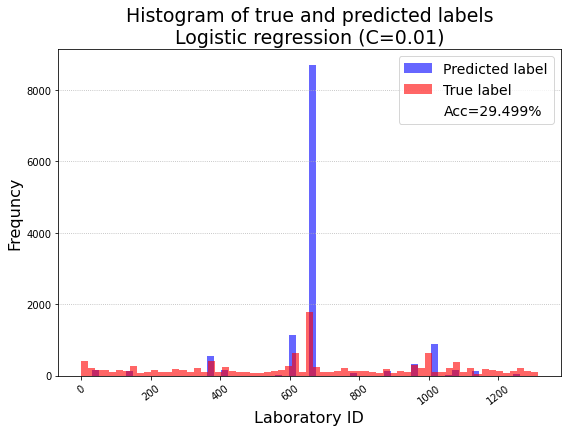

In [14]:
plt.figure(figsize=(9,6))
plt.grid(ls='dotted', axis='y')
plt.hist(y_pred_LogReg1, bins=int(max(np.unique(y_pred_LogReg1))/20), fc=(0, 0, 1, 0.6), label='Predicted label')
plt.hist(y_ts, bins=int(max(np.unique(y_ts))/20), fc=(1, 0, 0, 0.6), label='True label')
plt.plot(0, 0, 'x', ms=0, c='white', label=f'Acc={round(accuracy(y_pred_LogReg1, y_ts, print_or_return=False)*100, 3)}%')
plt.title('Histogram of true and predicted labels\nLogistic regression (C=0.01)', fontsize=fs+3)
plt.xlabel('Laboratory ID', fontsize=fs)
plt.xticks(rotation=37)
plt.ylabel('Frequncy', fontsize=fs)
plt.legend(fontsize=fs-2)
plt.savefig(google_drive_path+'images/hist_logreg1.pdf', bbox_inches='tight')
plt.show()



```python
%%time
LogReg_c1000 = LogReg(random_state=0, C=1000, max_iter=500, n_jobs=-1)
LogReg_c1000.fit(x_tr, y_tr)
with open(google_drive_path+'data/LogReg_C=1000', 'wb') as f:
    pickle.dump(LogReg_c1000, f)
```


```
CPU times: user 5.16 s, sys: 826 ms, total: 5.98 s
Wall time: 15min 56s
```







In [15]:
with open(google_drive_path+'data/LogReg_C=1000', 'rb') as f:
    LogReg_c1000 = pickle.load(f)
y_pred_LogReg2 = LogReg_c1000.predict(x_ts)
accuracy(y_pred_LogReg2, y_ts, model_name='LogReg', print_or_return=True)

Accuracy of LogReg model: 39.511 %


C:\Users\Menko_Balazs\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


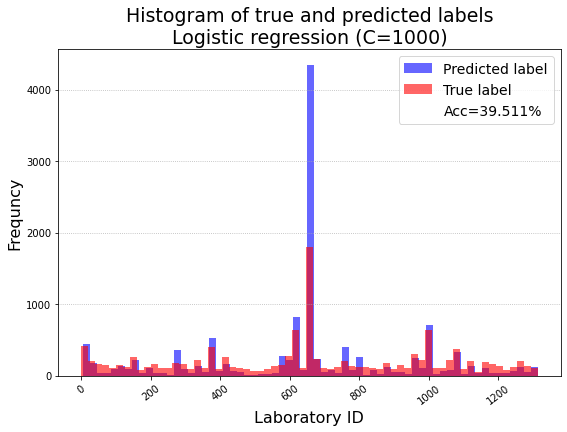

In [16]:
plt.figure(figsize=(9,6))
plt.grid(ls='dotted', axis='y')
plt.hist(y_pred_LogReg2, bins=int(max(np.unique(y_pred_LogReg2))/20), fc=(0, 0, 1, 0.6), label='Predicted label')
plt.hist(y_ts, bins=int(max(np.unique(y_ts))/20), fc=(1, 0, 0, 0.6), label='True label')
plt.plot(0, 0, 'x', ms=0, c='white', label=f'Acc={round(accuracy(y_pred_LogReg2, y_ts, print_or_return=False)*100, 3)}%')
plt.title('Histogram of true and predicted labels\nLogistic regression (C=1000)', fontsize=fs+3)
plt.xlabel('Laboratory ID', fontsize=fs)
plt.xticks(rotation=37)
plt.ylabel('Frequncy', fontsize=fs)
plt.legend(fontsize=fs-2)
plt.savefig(google_drive_path+'images/hist_logreg2.pdf', bbox_inches='tight')
plt.show()

---
## 3) [Decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) & [Random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [17]:
Dec_Tr_clf = DecisionTreeClassifier(criterion='gini', max_features='log2', random_state=42).fit(x_tr, y_tr)
imp_Dec_Tr = Dec_Tr_clf.feature_importances_
imp_Dec_Tr, idx = zip(*sorted(zip(imp_Dec_Tr, data.columns), reverse=True))
print('Most important features according to decision tree:')
for i in range(5):
    print(f'{i+1}. --- {idx[i]} - {np.round(imp_Dec_Tr[i]*100, 3)}%')

Most important features according to decision tree:
1. --- selectable_markers_puromycin - 9.336%
2. --- bacterial_resistance_kanamycin - 8.018%
3. --- species_human - 7.45%
4. --- selectable_markers_neomycin - 6.237%
5. --- species_synthetic - 5.954%


In [18]:
y_pred_DecTR = Dec_Tr_clf.predict(x_ts)
accuracy(y_pred_DecTR, y_ts, 'the Random Forest')

Accuracy of the Random Forest model: 41.86 %


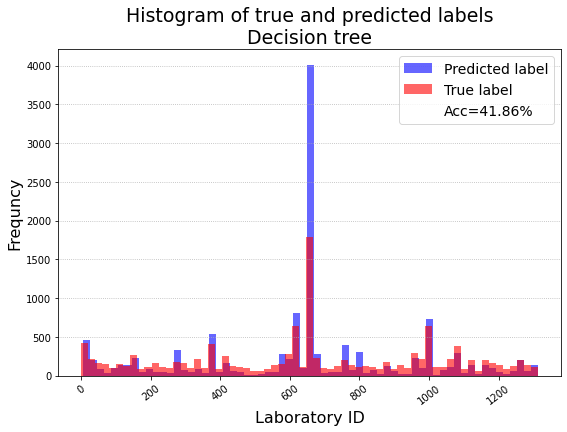

In [19]:
plt.figure(figsize=(9,6))
plt.grid(ls='dotted', axis='y')
plt.hist(y_pred_DecTR, bins=int(max(np.unique(y_pred_DecTR))/20), fc=(0, 0, 1, 0.6), label='Predicted label')
plt.hist(y_ts, bins=int(max(np.unique(y_ts))/20), fc=(1, 0, 0, 0.6), label='True label')
plt.plot(0, 0, 'x', ms=0, c='white', label=f'Acc={round(accuracy(y_pred_DecTR, y_ts, print_or_return=False)*100, 3)}%')
plt.title('Histogram of true and predicted labels\nDecision tree', fontsize=fs+3)
plt.xlabel('Laboratory ID', fontsize=fs)
plt.xticks(rotation=37)
plt.ylabel('Frequncy', fontsize=fs)
plt.legend(fontsize=fs-2)
plt.savefig(google_drive_path+'images/hist_DecTR.pdf', bbox_inches='tight')
plt.show()

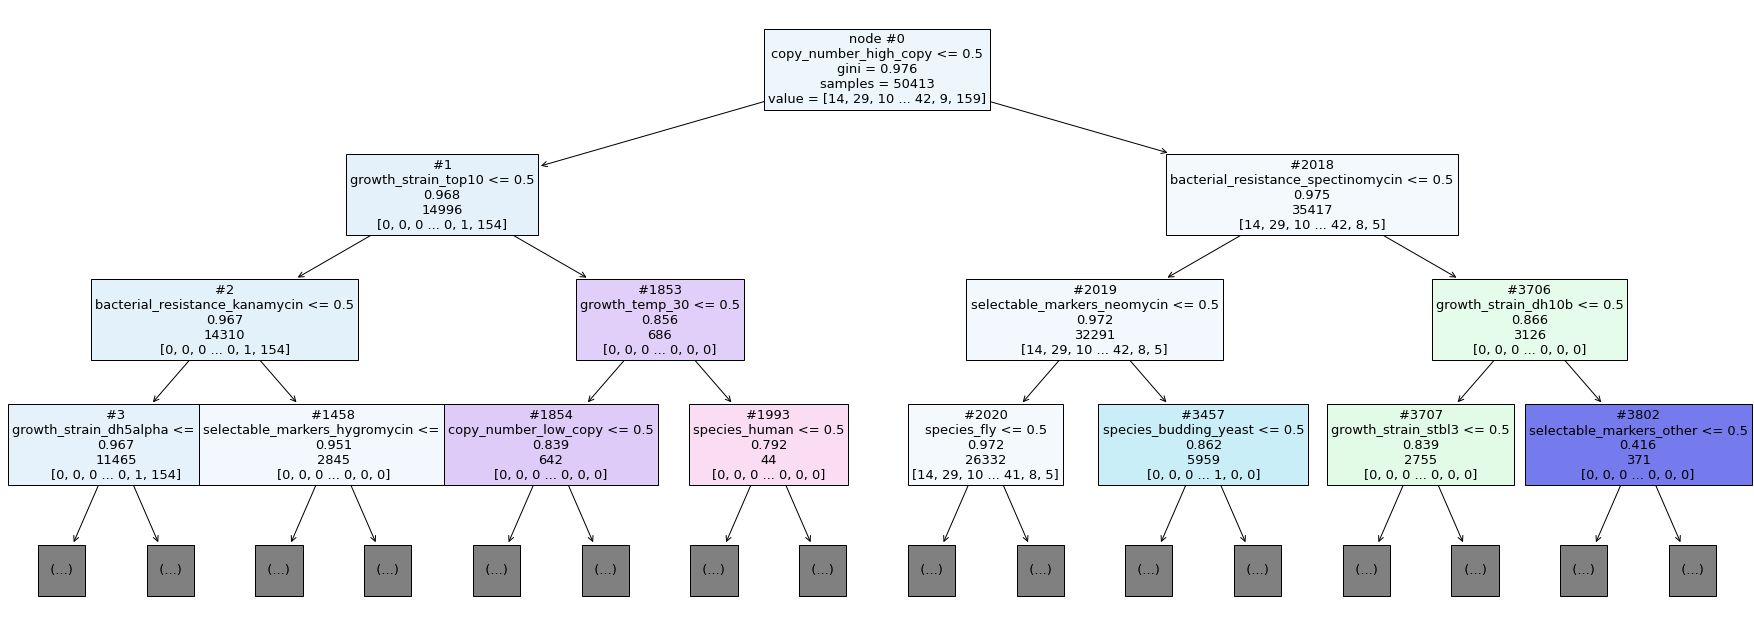

In [20]:
mpl.rcParams['text.color'] = 'black'

fig, ax = plt.subplots(ncols=1, figsize=[25, 9])
colors = ['red', 'blue']

artists = plot_tree(Dec_Tr_clf, 
                    max_depth=3,
                    feature_names=data.columns, 
                    label='root', 
                    filled=True,
                    node_ids=True,
                    fontsize=fs-3,
                    ax=ax
                    )

plt.tight_layout()
plt.savefig(google_drive_path+'images/Tree_max_depth=3.pdf', bbox_inches='tight')
plt.show()

---

In [21]:
RandomForest_clf = RandomForestClassifier(random_state=137, n_jobs=-1, n_estimators=140, max_features='log2', min_samples_split=4)
RandomForest_clf.fit(x_tr, y_tr)
imp_RandomForest = RandomForest_clf.feature_importances_
imp_RandomForest, sorted_col1 = zip(*sorted(zip(imp_RandomForest, data.columns), reverse=True))
print('Most important features according to random forst:')
for i in range(5):
    print(f'{i+1}. --- {sorted_col1[i]} - {np.round(imp_RandomForest[i]*100, 3)}%')

Most important features according to random forst:
1. --- selectable_markers_puromycin - 8.284%
2. --- selectable_markers_neomycin - 6.802%
3. --- species_human - 6.155%
4. --- bacterial_resistance_kanamycin - 5.248%
5. --- species_synthetic - 5.231%


In [22]:
y_pred_RF = RandomForest_clf.predict(x_ts)
accuracy(y_pred_RF, y_ts, 'the Random Forest')

Accuracy of the Random Forest model: 42.003 %


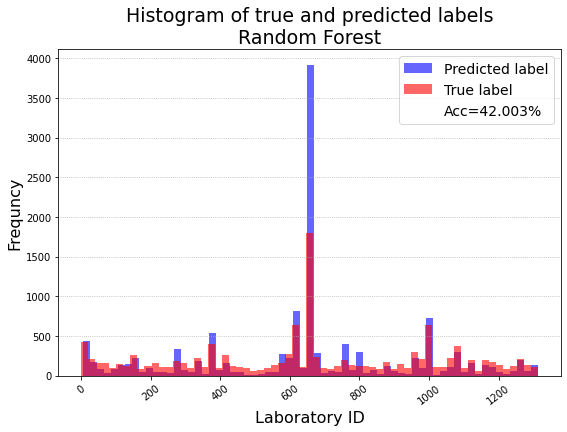

In [23]:
plt.figure(figsize=(9,6))
plt.grid(ls='dotted', axis='y')
plt.hist(y_pred_RF, bins=int(max(np.unique(y_pred_RF))/20), fc=(0, 0, 1, 0.6), label='Predicted label')
plt.hist(y_ts, bins=int(max(np.unique(y_ts))/20), fc=(1, 0, 0, 0.6), label='True label')
plt.plot(0, 0, 'x', ms=0, c='white', label=f'Acc={round(accuracy(y_pred_RF, y_ts, print_or_return=False)*100, 3)}%')
plt.title('Histogram of true and predicted labels\nRandom Forest', fontsize=fs+3)
plt.xlabel('Laboratory ID', fontsize=fs)
plt.xticks(rotation=37)
plt.ylabel('Frequncy', fontsize=fs)
plt.legend(fontsize=fs-2)
plt.savefig(google_drive_path+'images/hist_RF.pdf', bbox_inches='tight')
plt.show()

---
## 4) Neural network



```
model_NN = tf.keras.models.Sequential([ 
    tf.keras.layers.Input(shape=(x_tr.shape[1:]), name='Input_layer'),
    tf.keras.layers.Dense(600, activation='relu'),
    tf.keras.layers.Dense(800, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1300, activation='relu'),
    tf.keras.layers.Dense(y_tr_ohe[0].shape[0], activation='softmax', name='Output_layer')],
 name="Model-Neural_Network")

model_NN.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_NN.summary()
```

```
Model: "Model-Neural_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 dense (Dense)               (None, 600)               24000     
                                                                 
 dense_1 (Dense)             (None, 800)               480800    
                                                                 
 dense_2 (Dense)             (None, 1000)              801000    
                                                                 
 dense_3 (Dense)             (None, 1300)              1301300   
                                                                 
 Output_layer (Dense)        (None, 1314)              1709514   
                                                                 
=================================================================
Total params: 4,316,614
Trainable params: 4,316,614
Non-trainable params: 0
_________________________________________________________________
```

```python
%%time
history_NN = model_NN.fit(x=x_tr, y=y_tr_ohe, batch_size=64, epochs=20, validation_data=(x_ts, y_ts_ohe))
```



```
Epoch 1/20
788/788 [==============================] - 7s 5ms/step - loss: 3.9785 - accuracy: 0.3219 - val_loss: 3.2840 - val_accuracy: 0.3678
Epoch 2/20
788/788 [==============================] - 3s 4ms/step - loss: 2.9423 - accuracy: 0.3822 - val_loss: 2.9878 - val_accuracy: 0.3819
Epoch 3/20
788/788 [==============================] - 4s 5ms/step - loss: 2.7073 - accuracy: 0.3993 - val_loss: 2.9158 - val_accuracy: 0.4013
Epoch 4/20
788/788 [==============================] - 3s 4ms/step - loss: 2.5946 - accuracy: 0.4089 - val_loss: 2.8630 - val_accuracy: 0.4081
Epoch 5/20
788/788 [==============================] - 4s 5ms/step - loss: 2.5262 - accuracy: 0.4134 - val_loss: 2.8612 - val_accuracy: 0.4077
Epoch 6/20
788/788 [==============================] - 3s 4ms/step - loss: 2.4825 - accuracy: 0.4156 - val_loss: 2.8370 - val_accuracy: 0.4100
Epoch 7/20
788/788 [==============================] - 3s 4ms/step - loss: 2.4510 - accuracy: 0.4185 - val_loss: 2.8551 - val_accuracy: 0.4072
Epoch 8/20
788/788 [==============================] - 4s 5ms/step - loss: 2.4259 - accuracy: 0.4227 - val_loss: 2.8447 - val_accuracy: 0.4123
Epoch 9/20
788/788 [==============================] - 3s 4ms/step - loss: 2.4079 - accuracy: 0.4247 - val_loss: 2.8268 - val_accuracy: 0.4140
Epoch 10/20
788/788 [==============================] - 4s 4ms/step - loss: 2.3923 - accuracy: 0.4256 - val_loss: 2.8369 - val_accuracy: 0.4129
Epoch 11/20
788/788 [==============================] - 4s 4ms/step - loss: 2.3786 - accuracy: 0.4281 - val_loss: 2.8415 - val_accuracy: 0.4115
Epoch 12/20
788/788 [==============================] - 4s 4ms/step - loss: 2.3702 - accuracy: 0.4284 - val_loss: 2.8443 - val_accuracy: 0.4086
Epoch 13/20
788/788 [==============================] - 4s 4ms/step - loss: 2.3582 - accuracy: 0.4285 - val_loss: 2.8520 - val_accuracy: 0.4192
Epoch 14/20
788/788 [==============================] - 4s 6ms/step - loss: 2.3511 - accuracy: 0.4292 - val_loss: 2.8703 - val_accuracy: 0.4146
Epoch 15/20
788/788 [==============================] - 4s 5ms/step - loss: 2.3438 - accuracy: 0.4305 - val_loss: 2.8735 - val_accuracy: 0.4149
Epoch 16/20
788/788 [==============================] - 3s 4ms/step - loss: 2.3365 - accuracy: 0.4315 - val_loss: 2.8803 - val_accuracy: 0.4167
Epoch 17/20
788/788 [==============================] - 4s 4ms/step - loss: 2.3337 - accuracy: 0.4311 - val_loss: 2.8906 - val_accuracy: 0.4149
Epoch 18/20
788/788 [==============================] - 4s 5ms/step - loss: 2.3274 - accuracy: 0.4328 - val_loss: 2.8961 - val_accuracy: 0.4169
Epoch 19/20
788/788 [==============================] - 4s 4ms/step - loss: 2.3231 - accuracy: 0.4322 - val_loss: 2.9016 - val_accuracy: 0.4141
Epoch 20/20
788/788 [==============================] - 4s 4ms/step - loss: 2.3198 - accuracy: 0.4333 - val_loss: 2.9040 - val_accuracy: 0.4198
CPU times: user 1min 15s, sys: 10.4 s, total: 1min 25s
Wall time: 1min 22s
```



```python
tf.keras.models.save_model(
    model_NN,
    google_drive_path+'data/model_NN.keras',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)
np.save(google_drive_path+'data/history_NN.npy', history_NN.history)
```

In [24]:
model_NN = tf.keras.models.load_model(google_drive_path+'data/model_NN.keras')
history_NN = np.load(google_drive_path+'data/history_NN.npy', allow_pickle='TRUE').item()

Train loss: 2.32
Test loss: 2.904


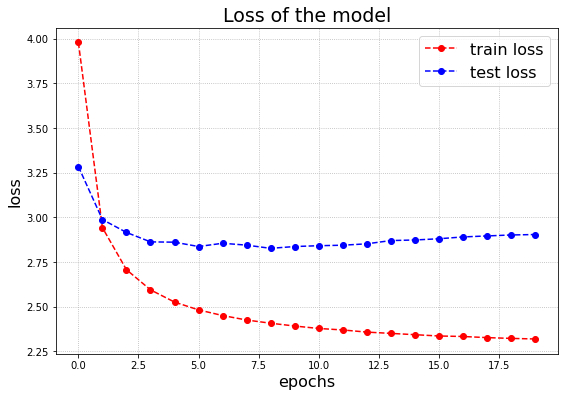

Train accuracy: 0.433
Test accuracy: 0.42


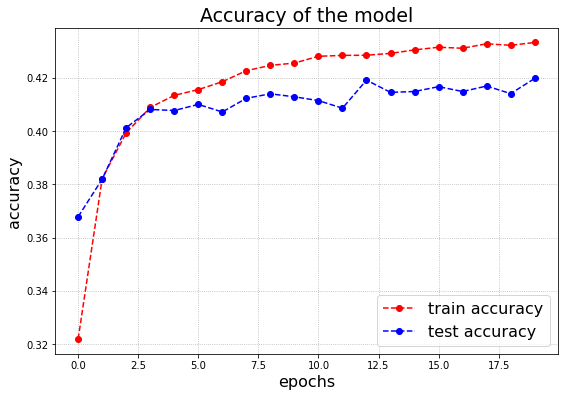

In [25]:
plot_history(history_NN['loss'], history_NN['val_loss'], 'loss', save_as='NN_loss')
plot_history(history_NN['accuracy'], history_NN['val_accuracy'], 'accuracy', save_as='NN_acc')

In [26]:
y_pred_NN_ohe = model_NN.predict(x_ts)
y_pred_NN = np.argmax(y_pred_NN_ohe, axis=1)

accuracy(y_pred_NN, y_ts, 'Neural Network')

394/394 [==============================] - 3s 7ms/step
Accuracy of Neural Network model: 41.979 %


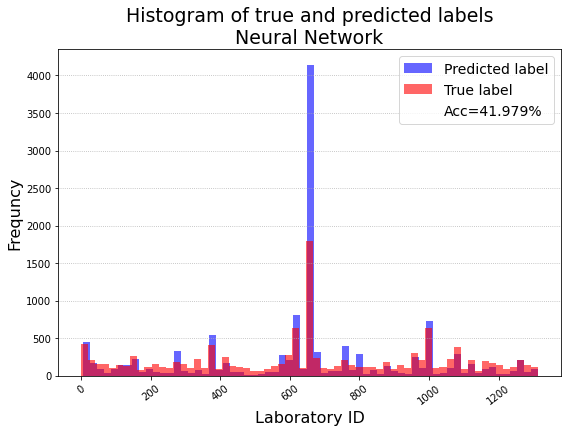

In [27]:
plt.figure(figsize=(9,6))
plt.grid(ls='dotted', axis='y')
plt.hist(y_pred_NN, bins=int(max(np.unique(y_pred_NN))/20), fc=(0, 0, 1, 0.6), label='Predicted label')
plt.hist(y_ts, bins=int(max(np.unique(y_ts))/20), fc=(1, 0, 0, 0.6), label='True label')
plt.plot(0, 0, 'x', ms=0, c='white', label=f'Acc={round(accuracy(y_pred_NN, y_ts, print_or_return=False)*100, 3)}%')
plt.title('Histogram of true and predicted labels\nNeural Network', fontsize=fs+3)
plt.xlabel('Laboratory ID', fontsize=fs)
plt.xticks(rotation=37)
plt.ylabel('Frequncy', fontsize=fs)
plt.legend(fontsize=fs-2)
plt.savefig(google_drive_path+'images/hist_NN.pdf', bbox_inches='tight')
plt.show()

In [28]:
print(f'Restart & Run All - finished (in { round((datetime.now()-start_kernel).total_seconds(), 3) } seconds)')

Restart & Run All - finished (in 48.913 seconds)
